In [ ]:
#Elements of the code based on tensorflow tutorial: https://www.tensorflow.org/tutorials/structured_data/time_series

In [ ]:
#Import the required libraries 
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import pylab as pl
from sklearn.metrics import mean_absolute_error as mae
from numpy import fft

In [ ]:
#Request access from the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load required data
df = pd.read_csv("/content/drive/MyDrive/neworiginal.csv")
weather = pd.read_csv("/content/drive/MyDrive/ssc2020_hourly_weather.csv")


In [ ]:
#Observe the Data set
df.head()

,Hour,Total.Energy.Use.from.Electricity..MW.,Month,Day,newyear
0,1,14745,1,1,1
1,2,14280,1,1,1
2,3,13821,1,1,1
3,4,13239,1,1,1
4,5,13236,1,1,1


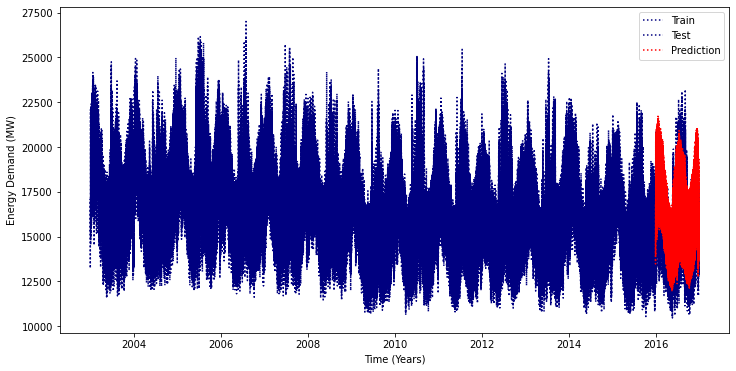

In [ ]:
# Baseline Model 

df2 = pd.concat([weather, df], axis=1)

df2 = df2.set_index(pd.DatetimeIndex(df2['time']))
df2 = df2.drop(['time'], axis=1)

train_og = df2.iloc[:(len(df)-365*24)]
test_og = df2.iloc[(len(df)-365*24):]

#Taking the average hourly demand from the first 13 years (predictions)

predictions_temp = train_og.groupby(['Month','Day', 'Hour']).mean().reset_index()
predictions = pd.DataFrame(predictions_temp['Total.Energy.Use.from.Electricity..MW.']).rename(columns={'Total.Energy.Use.from.Electricity..MW.': 'Prediction'})
len(predictions) # 8783
predictions
test_og.reset_index()

#Merging test with the predictions 

mpl.rcParams['figure.figsize'] = (12, 6)

baseline_mae = pd.concat([test_og.reset_index(), predictions], axis=1)
len(baseline_mae)
baseline_mae['diff'] = abs(baseline_mae['Prediction']-baseline_mae['Total.Energy.Use.from.Electricity..MW.'])
baselineMAE = baseline_mae['diff'].sum()/baseline_mae['diff'].count()
baselineMAE

baseline_mae = baseline_mae.set_index(pd.DatetimeIndex(baseline_mae['time']))

#plot the predictions for test set
plt.plot(train_og['Total.Energy.Use.from.Electricity..MW.'], label='Train', color='navy', linestyle=':')
plt.plot(test_og['Total.Energy.Use.from.Electricity..MW.'], label='Test',  color='navy', linestyle=':')
plt.plot(baseline_mae['Prediction'], label='Prediction', color='red', linestyle=':')
plt.xlabel('Time (Years)')
plt.ylabel('Energy Demand (MW)')
plt.legend(loc='best')
plt.show()

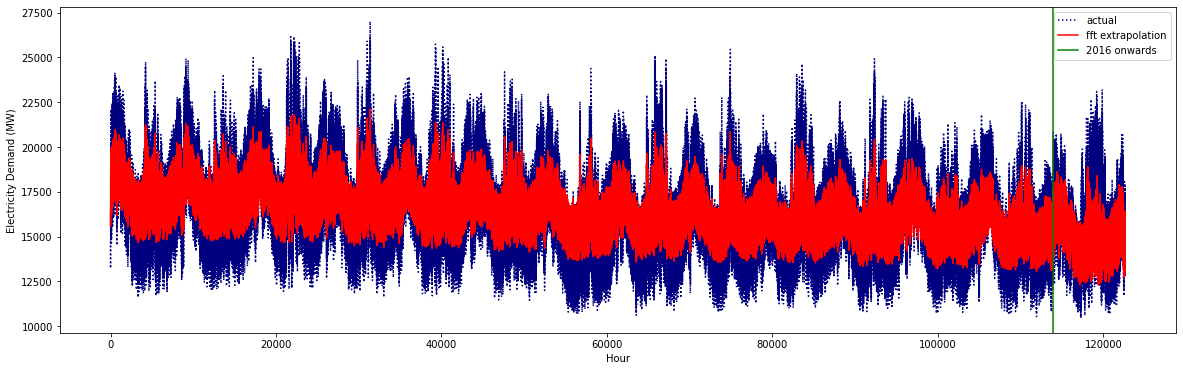

1490.125968580703

In [ ]:
# the Fast Fourier Transform Model

MW = df["Total.Energy.Use.from.Electricity..MW."]
train = MW[0:113880]
test = MW[113880:]

# convert train and test to type np.array
train = train.values
test = test.values

# the function
def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 10000                    # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x (for our data, array([-2.06713427e-02,  1.78138881e+04]))
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = range(n)
    # sort indexes by frequency, lower -> higher
    # indexes.sort(key = lambda i: np.absolute(f[i]))
    indexes = list(range(n))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t
    
# feed in the electricity data
x = train                       # 113880
n_predict = 8760                # predict 8760 data points
extrapolation = fourierExtrapolation(x, n_predict)

# plot
mpl.rcParams['figure.figsize'] = (20, 6)
pl.plot(np.arange(0, MW.size), MW, 'navy', label = 'actual', linestyle = ":")
pl.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'fft extrapolation')
pl.axvline(x=113880, color = 'g', label = '2016 onwards')

plt.xlabel("Hour")
plt.ylabel("Electricity Demand (MW)")
pl.legend()
pl.show()

#mae
mae(test, extrapolation[113880:])

In [ ]:
#Reload the data
df = pd.read_csv("/content/drive/MyDrive/neworiginal.csv")
#Change dataset to training, validation, and test set respectively
n = len(df)
training_set = df[:(len(df)-365*24*3)] #11 years
validation_set = df[(len(df)-365*24*3):len(df)-365*24] #2 years
testing_set = df[(len(df)-365*24):] #1 year

num_features = df.shape[1] #df.shape is (122736, 5)
#We should expect 5 for 'Hour', 'Total.Energy...', 'Month', 'Day', 'newyear' 
print(num_features)

5


In [ ]:
#Obtain mean and standard deviation of the training set to then normalize all 3 datasets with
training_mean = training_set.mean()
training_std = training_set.std()

#Normalize the values
training_set = (training_set - training_mean) / training_std
validation_set = (validation_set - training_mean) / training_std
testing_set = (testing_set - training_mean) / training_std


In [ ]:
#Create an object for the sliding window
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=training_set, val_df=validation_set, test_df=testing_set,
               label_columns=None):
    
    #Save raw data based off training, validation, and test sets respectively
    self.train_df = training_set
    self.val_df = validation_set
    self.test_df = testing_set

    #Get the column indices per user request
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(training_set.columns)}

    # Work out the window parameters.
    self.input_width = input_width #How many inputs to take
    self.label_width = label_width #How long the 'output' should be 
    self.shift = shift #How far to shift each time 

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width #Where to begin
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels
  
  def plot(self, model=None, plot_col='Total.Energy.Use.from.Electricity..MW.', max_subplots=1):
    inputs, labels = self.example
    plt.figure(figsize=(28, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel('Energy Demand (MW)')
      plt.plot(self.input_indices, (inputs[n, :, plot_col_index]*training_std['Total.Energy.Use.from.Electricity..MW.'])+ training_mean['Total.Energy.Use.from.Electricity..MW.'],
              label='Inputs', marker='.', zorder=-10, color='navy')

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, (labels[n, :, label_col_index]*training_std['Total.Energy.Use.from.Electricity..MW.'])+ training_mean['Total.Energy.Use.from.Electricity..MW.'],
                  edgecolors='navy', label='Labels', s=30, marker='.')
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, (predictions[n, :, label_col_index]*training_std['Total.Energy.Use.from.Electricity..MW.']) + training_mean['Total.Energy.Use.from.Electricity..MW.'],
                    marker='.', edgecolors='red', label='Predictions', s=30)

      if n == 0:
        plt.legend()

    plt.xlabel('Time in hours')

  #This function creates a timeseries dataset with the keras function given the data passed in, the sequence_stride we want is 1 because we're moving the window by 1 each time
  #We want the data to be drawn in chronological order so 'shuffle' is set to False
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size=32)

    ds = ds.map(self.split_window)

    return ds
  
  #Create additional Class attributes
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
#NOTE: ONLY RUN THIS BLOCK OF CODE WHEN YOU WANT TO RUN THE STATEFUL MODEL, IN NO OTHER CASE SHOULD YOU RUN THIS BLOCK OF CODE
#SHOULD YOU RUN THIS BLOCK OF CODE, RUN THE 2 BLOCKS OF CODE ABOVE THE INITIAL WINDOW GENERATOR
#THIS BLOCK OF CODE IS USED TO CREATE A 2ND WINDOW GENERATOR FOR THE STATEFUL/STATELESS MODELS WITH 1 EPOCH AND 1 BATCH SIZE
df = pd.DataFrame(df['Total.Energy.Use.from.Electricity..MW.'])
n = len(df)
training_set = df[:(len(df)-365*24*3)] #11 years
validation_set = df[(len(df)-365*24*3):len(df)-365*24] #2 years
testing_set = df[(len(df)-365*24):] #1 year

num_features = df.shape[1] #df.shape is (122736, 5)
#We should expect 5 for 'Hour', 'Total.Energy...', 'Month', 'Day', 'newyear' 
print(num_features)
training_mean = training_set.mean()
training_std = training_set.std()

#Normalize the values
training_set = (training_set - training_mean) / training_std
validation_set = (validation_set - training_mean) / training_std
testing_set = (testing_set - training_mean) / training_std

1


In [ ]:
#Create an object for the sliding window
class WindowGenerator2():
  def __init__(self, input_width, label_width, shift,
               train_df=training_set, val_df=validation_set, test_df=testing_set,
               label_columns=None):
    
    #Save raw data based off training, validation, and test sets respectively
    self.train_df = training_set
    self.val_df = validation_set
    self.test_df = testing_set

    #Get the column indices per user request
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(training_set.columns)}

    # Work out the window parameters.
    self.input_width = input_width #How many inputs to take
    self.label_width = label_width #How long the 'output' should be 
    self.shift = shift #How far to shift each time 

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width #Where to begin
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels
  
  def plot(self, model=None, plot_col='Total.Energy.Use.from.Electricity..MW.', max_subplots=1):
    inputs, labels = self.example
    plt.figure(figsize=(28, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel('Energy Demand (MW)')
      plt.plot(self.input_indices, (inputs[n, :, plot_col_index]*training_std['Total.Energy.Use.from.Electricity..MW.'])+ training_mean['Total.Energy.Use.from.Electricity..MW.'],
              label='Inputs', marker='.', zorder=-10, color='navy')

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, (labels[n, :, label_col_index]*training_std['Total.Energy.Use.from.Electricity..MW.'])+ training_mean['Total.Energy.Use.from.Electricity..MW.'],
                  edgecolors='navy', label='Labels', s=30, marker='.')
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, (predictions[n, :, label_col_index]*training_std['Total.Energy.Use.from.Electricity..MW.']) + training_mean['Total.Energy.Use.from.Electricity..MW.'],
                    marker='.', edgecolors='red', label='Predictions', s=30)

      if n == 0:
        plt.legend()

    plt.xlabel('Time in hours')

  #This function creates a timeseries dataset with the keras function given the data passed in, the sequence_stride we want is 1 because we're moving the window by 1 each time
  #We want the data to be drawn in chronological order so 'shuffle' is set to False
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size=1)

    ds = ds.map(self.split_window)

    return ds
  
  #Create additional Class attributes
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Total window size: 17520
Input indices: [   0    1    2 ... 8757 8758 8759]
Label indices: [ 8760  8761  8762 ... 17517 17518 17519]
Label column name(s): ['Total.Energy.Use.from.Electricity..MW.']

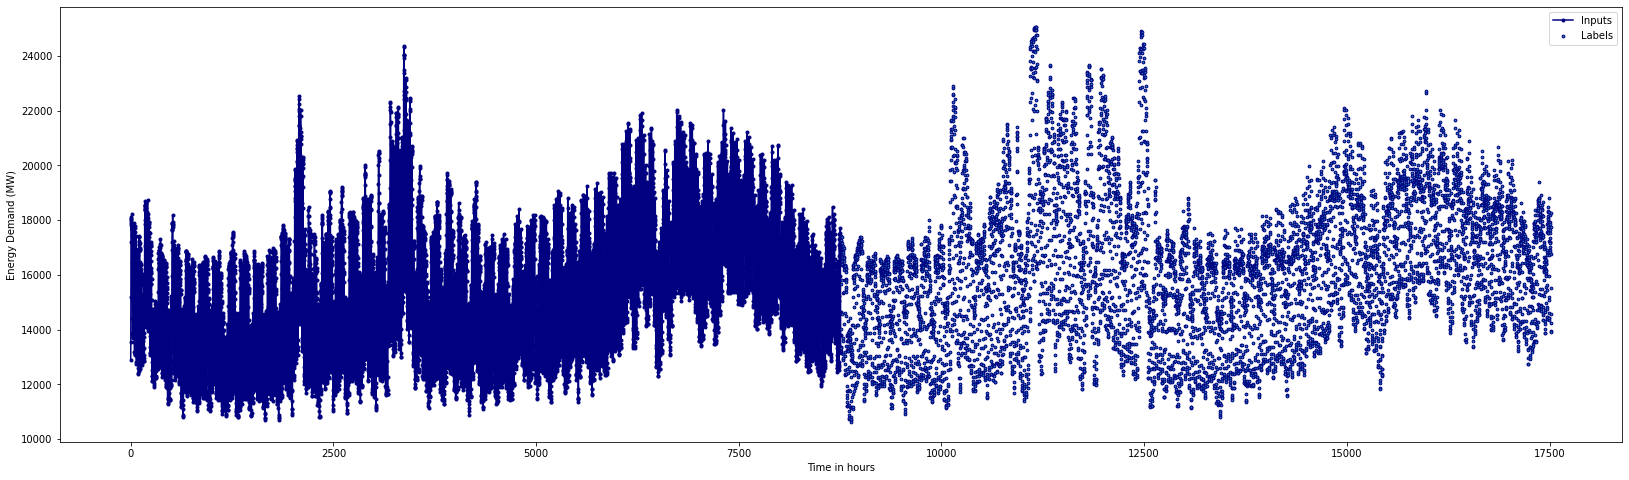

In [ ]:
label_steps = 8760 #How much to predict
#Recall shift is how much we want to 'move' our models prediction by, because we want to predict next YEARS data, we want to shift by 8760
window = WindowGenerator(input_width=8760,
                               label_width=label_steps,
                               shift=label_steps,
                               label_columns = ['Total.Energy.Use.from.Electricity..MW.'])
#Displays how the plot works,given the first 8760 inputs, plots the next 8760 values
window.plot()
window

In [ ]:
#Select how many epochs you'd like here:
epochsU = 3
epochsS = 1

In [ ]:
#observe validation loss
#patience tells us after how many epochs the model should stop running if it does see improvement, we are using 3 epochs so select 3-1=2
#We select min, so training will stop when what we're monitoring, 'validation loss' no longer decreases
def getStopping(patience):
  #Pre: Pass in a value you want for patience (ideally 2)
  #Post: Return a tensorflow object with the respective early stopping parameters
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  return early_stopping

In [ ]:
def fit_model(model, window, epochs):
  #Pre: Pass in a model with the respective epochs to train it with and a window
  #Post: Return the fitted model

  #Get the early stopping object
  early = getStopping(2)

  #Pass in the window training and validation set
  fit = model.fit(window.train, epochs = epochs, callbacks = [early], validation_data = window.val)

In [ ]:
#So the steps are:
#1. Create the model
#2. Compile the Model
#3. Fit the model


In [ ]:
#Create a pair of dictionaries that record the performance
validation_performance = {}
performance = {}

In [ ]:
newWindow = WindowGenerator2(input_width=8760,
                               label_width=label_steps,
                               shift=label_steps,
                               label_columns = ['Total.Energy.Use.from.Electricity..MW.'])

In [ ]:
#Create a 1 LSTM 1 Dense layer STATEFUL model
#Set 1 epoch, 1 batch size (so the stateful runs)
#1. Create the model
stateful_model = tf.keras.Sequential()
stateful_model.add(tf.keras.layers.LSTM(32, batch_input_shape=(1,8760,1), stateful=True))
stateful_model.add(tf.keras.layers.Dense(label_steps*1,
                          kernel_initializer=tf.initializers.zeros()))
stateful_model.add(tf.keras.layers.Reshape([label_steps, 1]))

#2. Compile the model
stateful_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

#3. Fit the model
fitted_model = fit_model(stateful_model, newWindow, 1)

In [ ]:
#Create a 1 LSTM 1 Dense Layer STATELESS model
#set 1 epoch, 1 batch size (to compare it to the stateful)
#1. Create the model
stateless_model = tf.keras.Sequential()
stateless_model.add(tf.keras.layers.LSTM(32, return_sequences=False))
stateless_model.add(tf.keras.layers.Dense(label_steps*1,
                          kernel_initializer=tf.initializers.zeros()))
stateless_model.add(tf.keras.layers.Reshape([label_steps, 1]))

#2. Compile the model
stateless_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

#3. Fit the model
fitted_model = fit_model(stateless_model, newWindow, 1)

In [ ]:
#This is the single layer LSTM with features, batch_size 32 and 3 epochs
#1. Create a model
my_model = tf.keras.Sequential()
my_model.add(tf.keras.layers.LSTM(32, return_sequences=False, input_shape = (8760, num_features)))
#my_model.add(tf.keras.layers.LSTM(32))
my_model.add(tf.keras.layers.Dense(label_steps*1, kernel_initializer=tf.initializers.zeros()))
my_model.add(tf.keras.layers.Reshape([label_steps, 1]))

#2. Compile the model (this gets the stopping value already)
#loss = MSE tends to punish outliers more, select this
#Use the Adam optimizer with its default parameters
#Obvious that because we want to optimize mean absolute error we should select that as our metric to be evaluated during training and testing
my_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

#3. Fit the model
fitted_model = fit_model(my_model, window, epochsU)

In [ ]:
#Plot the prediction with the respective MAE
validation_performance['LSTM'] = my_model.evaluate(window.val)
performance['LSTM'] = my_model.evaluate(window.test, verbose=0)
window.plot(my_model)

In [ ]:
#Save the model now:
my_model.save("/content/drive/MyDrive/use_model_new")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/use_model_new/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/use_model_new/assets


In [ ]:
train_std['Total.Energy.Use.from.Electricity..MW.']

2624.681143300772

In [ ]:
train_mean['Total.Energy.Use.from.Electricity..MW.']

16789.0348173516